# HEAD HDF Utilities Demo

This notebook demonstrates how to use `head_hdf_utils.py` to:

1. Inspect the header of a HEAD acoustics `.hdf` file.
2. Read calibrated audio (Pa) and export stereo / mono WAV files.
3. Plot a Mark Analyzer-style 2-panel figure (waveform + Level vs. Time).


## Import and setup

In [15]:
import os
import numpy as np
import matplotlib.pyplot as plt

import head_hdf_utils as hutils


In [21]:
# Set path to your HDF file
hdf_path = "test files/BBA1009.hdf" 

# Quick header inspection (optional)
# hutils.inspect_head_hdf(hdf_path, n_bytes=4096)


In [22]:
# Parse header information only (optional, for checking)
info = hutils.parse_header_info(hdf_path)

print("Start of data      :", info.start_of_data)
print("Number of channels :", info.num_channels)
print("Number of scans    :", info.num_scans)
print("Delta value [s]    :", info.delta_value)
print("Sampling rate [Hz] :", info.fs)
print("Left calibration dB:", info.calibration_left_db)
print("Right calibration dB:", info.calibration_right_db)


Start of data      : 65536
Number of channels : 3
Number of scans    : 1513472
Delta value [s]    : 2.08333333333333e-05
Sampling rate [Hz] : 48000.00000000008
Left calibration dB: 114.00000001078
Right calibration dB: 114.00000001078


In [13]:
# Read audio and export WAVs (calibrated to Pa by default)

base = os.path.splitext(os.path.basename(hdf_path))[0]

audio, fs, info = hutils.read_head_file(
    hdf_path,
    output_stereo=f"{base}_stereo.wav",
    output_left=f"{base}_left.wav",
    output_right=f"{base}_right.wav",
    apply_calibration=True,  # convert to Pa using calibration in header
)

print("Audio shape:", audio.shape)  # (num_samples, 2)
print("Sampling rate:", fs, "Hz")


Saved stereo WAV to BBB10001_stereo.wav
Saved Left channel WAV to BBB10001_left.wav
Saved Right channel WAV to BBB10001_right.wav
Audio shape: (1531904, 2)
Sampling rate: 48000.00000000008 Hz


Saved figure to BBB10001_mark_style.png


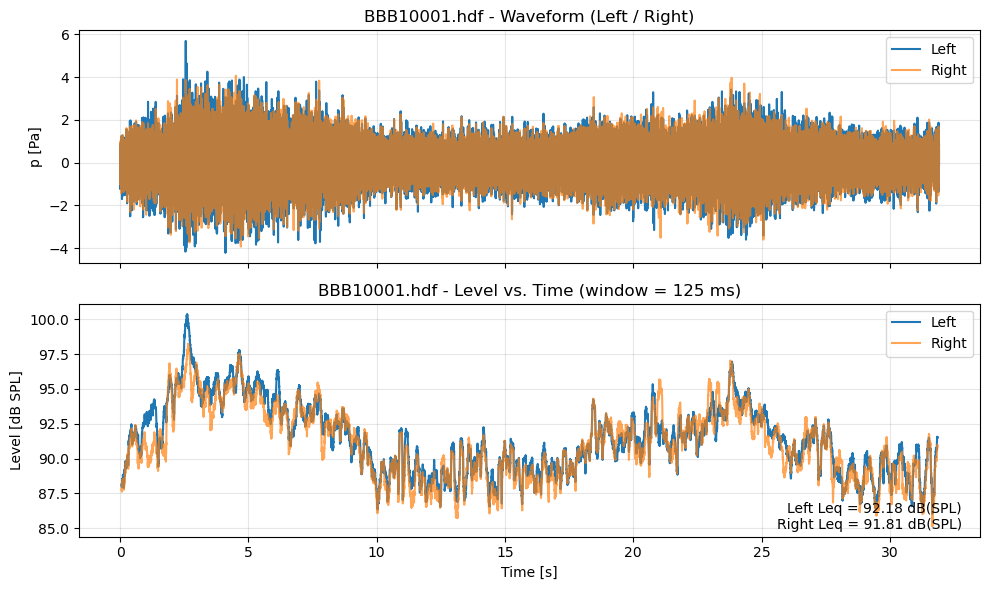

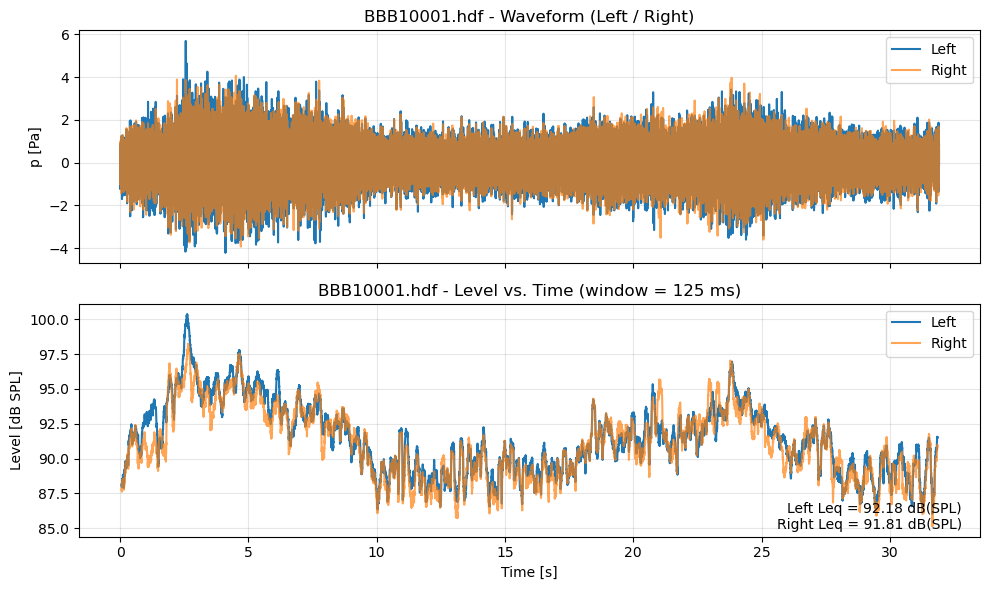

In [9]:
# Plot Mark Analyzer-style 2-panel figure:
# Top: waveform (Pa)
# Bottom: Level vs. Time (short-time RMS dB SPL)

hutils.plot_mark_style(
    audio,
    fs,
    window_seconds=0.125,
    channel_labels=("Left", "Right"),
    title_prefix=os.path.basename(hdf_path),
    show=True,
    save_path=f"{base}_mark_style.png",  # or None if you don't want to save
)


## loudness

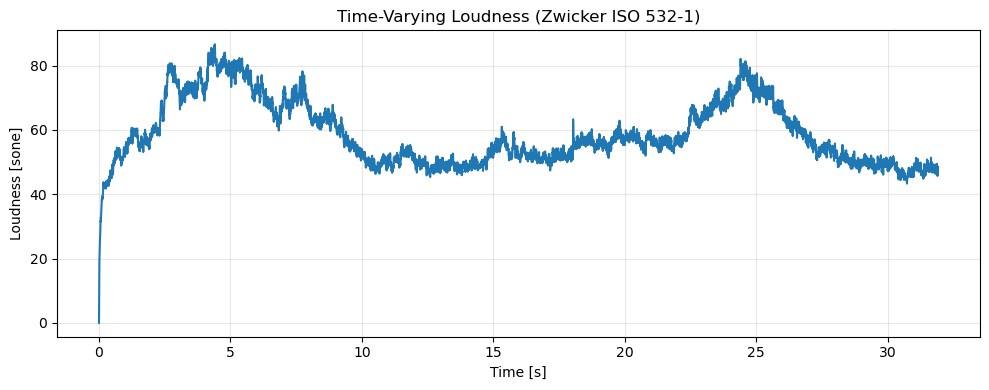

In [10]:
from psychoacoustics import compute_loudness_zwicker
from scipy.signal import resample

# 1. Load HDF file (calibrated output)
# read_head_file returns (audio, fs, info) so unpack all three
audio, fs, info = hutils.read_head_file("test files/BBB10001.hdf")

# 2. Extract left channel (unit: Pa)
left = audio[:, 0].astype(float)

# 2b. Resample to 48 kHz if required by the loudness function
TARGET_FS = 48000
if fs != TARGET_FS:
	new_len = int(round(len(left) * float(TARGET_FS) / fs))
	left = resample(left, new_len)
	fs = TARGET_FS

# 3. Compute loudness using Zwicker ISO 532-1
time_axis, N, N_specific, bark_axis = compute_loudness_zwicker(left, fs)

# 4. Plot loudness vs time
plt.figure(figsize=(10, 4))
plt.plot(time_axis, N)
plt.xlabel("Time [s]")
plt.ylabel("Loudness [sone]")
plt.title("Time-Varying Loudness (Zwicker ISO 532-1)")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()
